In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

summary_baseline_pipeline = pd.read_csv('summary_baseline.csv')
summary_full_pipeline = pd.read_csv("summary_full_pipeline.csv")
summary_sparql_llm_pipeline = pd.read_csv("summary_sparql_llm_pipeline.csv")

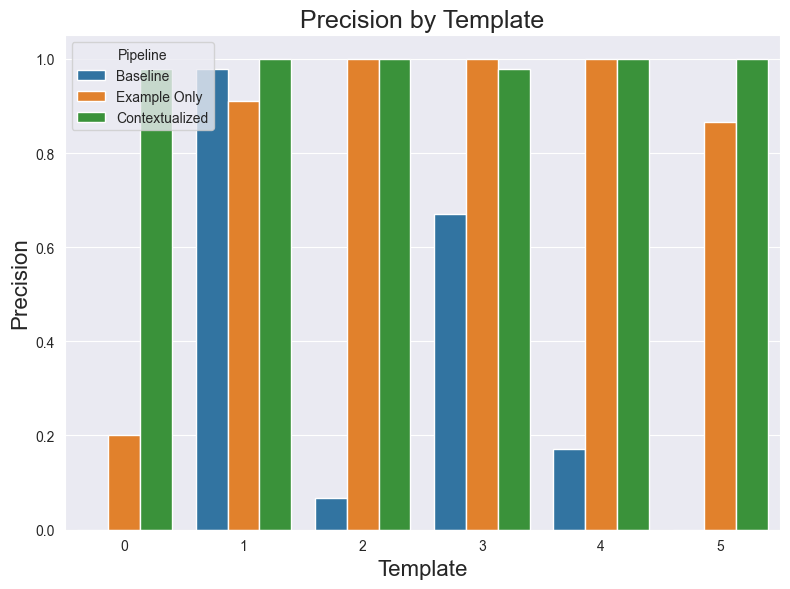

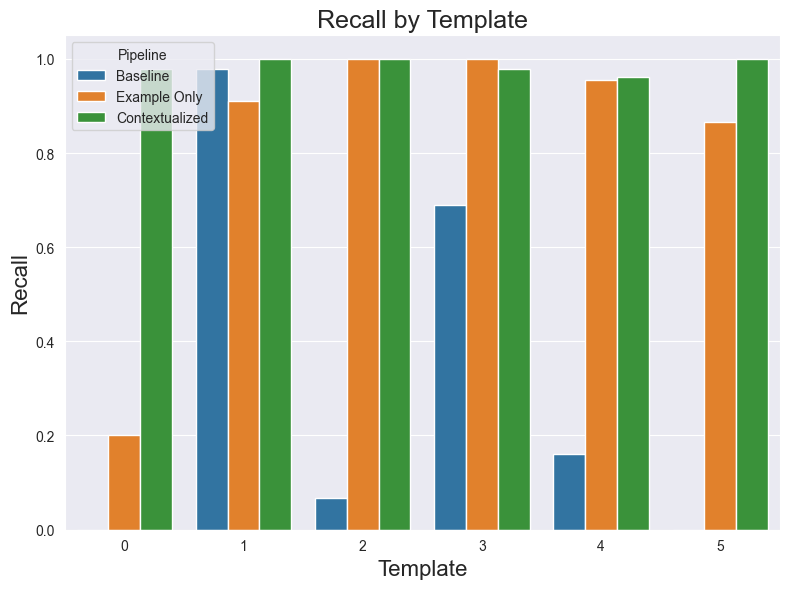

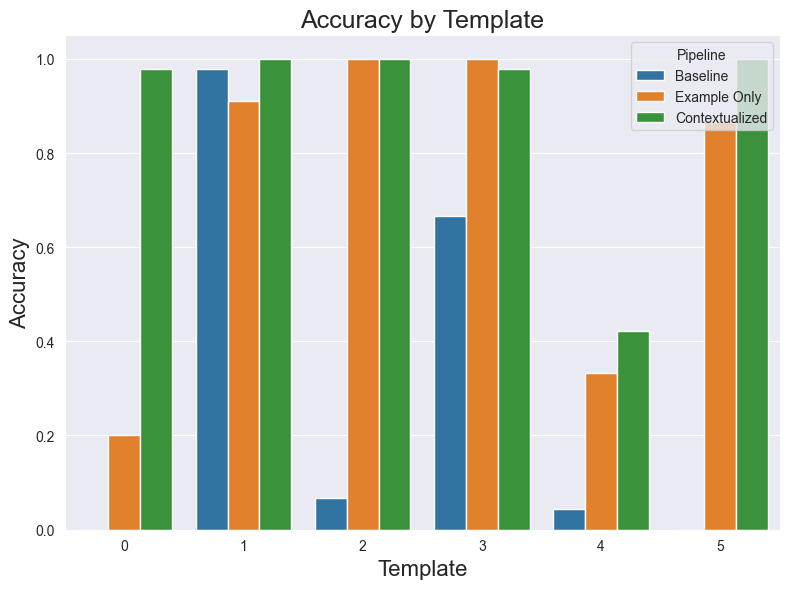

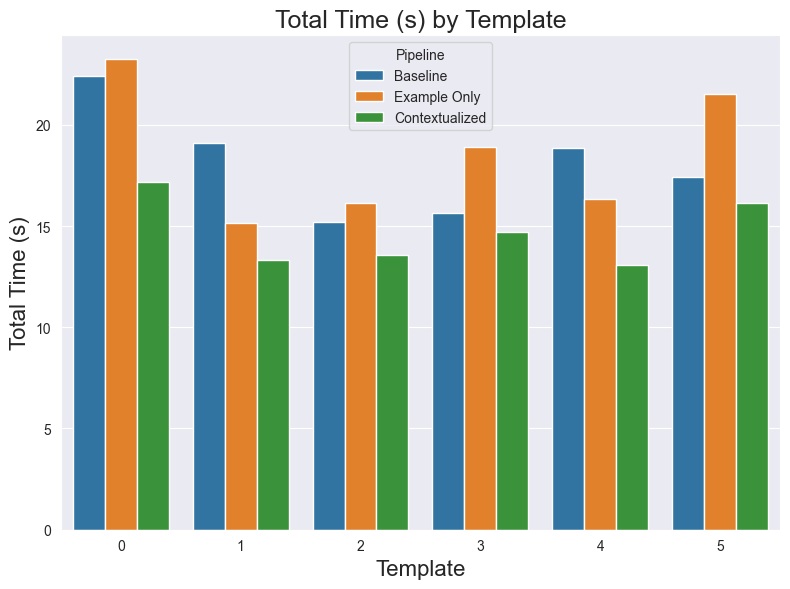

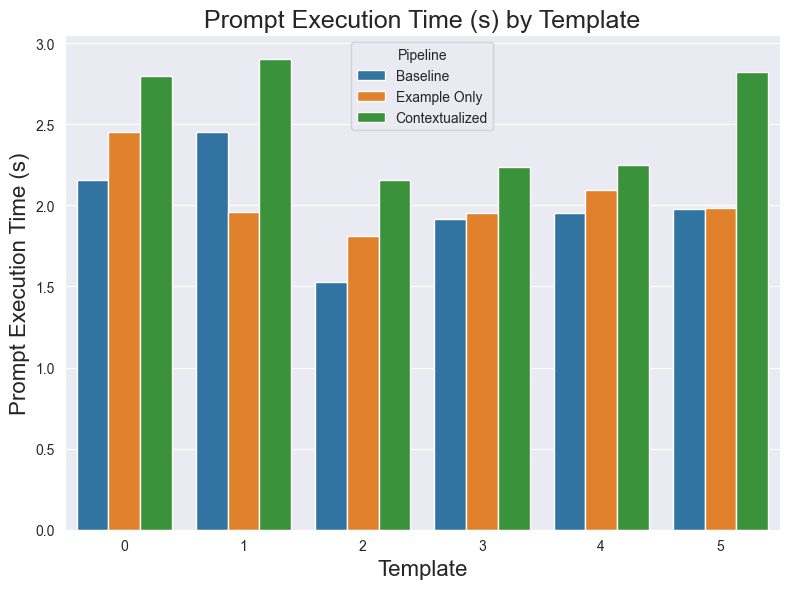

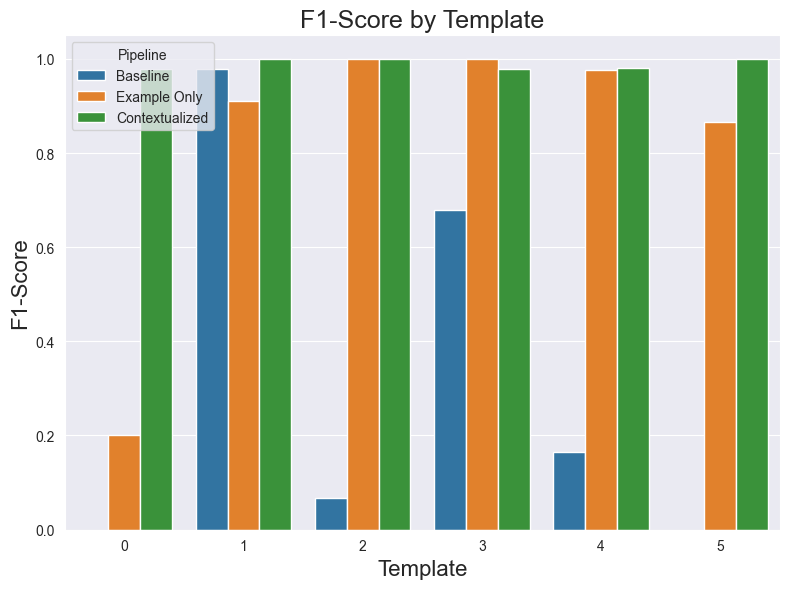

In [31]:
# Calculate F1-score for each pipeline
def compute_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall).replace({0: pd.NA})


summary_baseline_pipeline['f1'] = compute_f1(
    summary_baseline_pipeline['precision'], summary_baseline_pipeline['recall']
)
summary_full_pipeline['f1'] = compute_f1(
    summary_full_pipeline['precision'], summary_full_pipeline['recall']
)
summary_sparql_llm_pipeline['f1'] = compute_f1(
    summary_sparql_llm_pipeline['precision'], summary_sparql_llm_pipeline['recall']
)

# Metrics to plot
metrics = {
    "precision": "Precision",
    "recall": "Recall",
    "exact_match": "Accuracy",
    "total_time": "Total Time (s)",
    "initial_query_time": "Prompt Execution Time (s)",
    "f1": "F1-Score"
}

# Plot each metric
for metric, label in metrics.items():
    # Create comparison DataFrame
    metric_df = pd.DataFrame({
        'index': summary_baseline_pipeline.index,
        'Baseline': summary_baseline_pipeline[metric],
        'Example Only': summary_sparql_llm_pipeline[metric],
        'Contextualized': summary_full_pipeline[metric]
    })

    # Melt to long format for seaborn
    metric_long = metric_df.melt(id_vars='index', var_name='pipeline', value_name=label)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(data=metric_long, x='index', y=label, hue='pipeline')
    plt.title(f'{label} by Template', fontsize=18)
    plt.xlabel('Template', fontsize=16)
    plt.ylabel(label, fontsize=16)
    plt.legend(title='Pipeline')
    plt.tight_layout()
    plt.show()


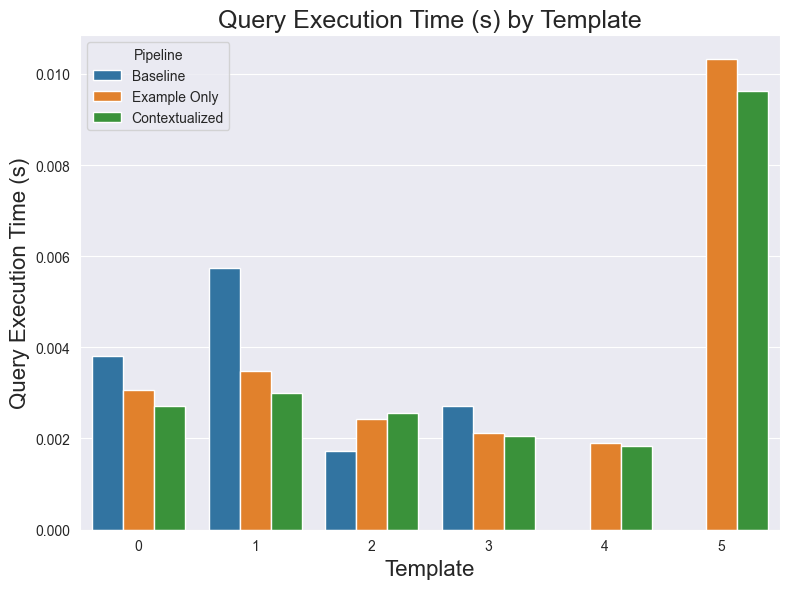

In [38]:
merged_baseline_pipeline = pd.read_csv('merged_baseline_pipeline.csv')
merged_full_pipeline = pd.read_csv("merged_full_pipeline.csv")
merged_sparql_llm = pd.read_csv("merged_sparql_llm_pipeline.csv")

merged_baseline_pipeline = merged_baseline_pipeline[merged_baseline_pipeline["exact_match"] == True]
merged_full_pipeline = merged_full_pipeline[merged_full_pipeline["exact_match"] == True]
merged_sparql_llm = merged_sparql_llm[merged_sparql_llm["exact_match"] == True]

import ast


def get_summary_from_merged_df(merged_df):
    # Prepare a boiled down summary df
    columns_to_keep = ["validation_time", "attempts", "initial_query_time", "final_query_execution_time", "total_time",
                       "template_rank",
                       'precision', 'recall', 'exact_match', "sparql_template"]

    reduced_merged_df = merged_df[columns_to_keep]

    # 1) Work on an explicit copy to avoid SettingWithCopyWarning
    reduced = reduced_merged_df.copy()

    # Safely parse and sum lists from string representations
    reduced["validation_time"] = reduced_merged_df["validation_time"].apply(
        lambda x: sum(ast.literal_eval(x)) if isinstance(x, str) else sum(x) if isinstance(x, list) else 0
    )

    # 2) Add exact_match_int
    reduced['exact_match_int'] = reduced['exact_match'].astype(int)

    # 3) Group and compute means on numeric columns only
    #    Pandas >= 1.5 lets you pass numeric_only=True to .mean()
    numeric_means = (
        reduced
        .groupby('sparql_template', as_index=False)
        .mean(numeric_only=True)
    )

    # 4) Convert the fraction into a percentage
    numeric_means['exact_match_percent'] = numeric_means['exact_match_int'] * 100

    # 5) (Optional) bring back the count per template
    counts = reduced.groupby('sparql_template').size().rename('n_queries').reset_index()
    summary = numeric_means.merge(counts, on='sparql_template')

    # 6) (Optional) drop the raw exact_match_int column
    summary = summary.drop(columns=['exact_match_int'])

    return summary


summary_baseline_pipeline = get_summary_from_merged_df(merged_baseline_pipeline)
summary_full_pipeline = get_summary_from_merged_df(merged_full_pipeline)
summary_sparql_llm_pipeline = get_summary_from_merged_df(merged_sparql_llm)

# Assign pipeline labels
summary_baseline_pipeline['pipeline'] = 'Baseline'
summary_full_pipeline['pipeline'] = 'Contextualized'
summary_sparql_llm_pipeline['pipeline'] = 'Example Only'

# Add an index column to preserve the row order for plotting
summary_baseline_pipeline = summary_baseline_pipeline.reset_index().rename(columns={'index': 'TemplateIndex'})

summary_sparql_llm_pipeline = summary_sparql_llm_pipeline.reset_index().rename(columns={'index': 'TemplateIndex'})
summary_full_pipeline = summary_full_pipeline.reset_index().rename(columns={'index': 'TemplateIndex'})

# Select relevant columns and combine
combined = pd.concat([
    summary_baseline_pipeline[['TemplateIndex', metric, 'pipeline']],
    summary_sparql_llm_pipeline[['TemplateIndex', metric, 'pipeline']],
    summary_full_pipeline[['TemplateIndex', metric, 'pipeline']]
])

# Rename metric column to generic "Value" for plotting
combined = combined.rename(columns={metric: 'Value'})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=combined, x='TemplateIndex', y='Value', hue='pipeline')
plt.title(f'{metrics[metric]} by Template', fontsize=18)
plt.xlabel('Template', fontsize=16)
plt.ylabel(metrics[metric], fontsize=16)
plt.legend(title='Pipeline')
plt.tight_layout()
plt.show()


